In [2]:
#!pip install nltk
import pandas as pd
import numpy as np
import json
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dumbo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
reviews = pd.read_json("Health_and_Personal_Care_5.json", lines = True)

In [4]:
r = pd.DataFrame(reviews)

In [5]:
reviews.count()

asin              346355
helpful           346355
overall           346355
reviewText        346355
reviewTime        346355
reviewerID        346355
reviewerName      343304
summary           346355
unixReviewTime    346355
dtype: int64

### Text Cleaning

In [6]:
review_data = reviews[['overall','reviewText','reviewerID']]

In [7]:
review_data['Rating'] = [1 if x < 3 else 0 for x in review_data['overall']]

C:\Users\Dumbo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [8]:
review_data.head()

,overall,reviewText,reviewerID,Rating
0,5,This is a great little gadget to have around. ...,ALC5GH8CAMAI7,0
1,4,I would recommend this for a travel magnifier ...,AHKSURW85PJUE,0
2,4,What I liked was the quality of the lens and t...,A38RMU1Y5TDP9,0
3,4,Love the Great point light pocket magnifier! ...,A1XZUG7DFXXOS4,0
4,5,This is very nice. You pull out on the magnifi...,A1MS3M7M7AM13X,0


In [9]:
reviews_list = review_data['reviewText']

### Tokenization and handling negation

In [10]:
def negation_handler(document):
    """
    To determine remove punctuation marks except apostrophes, tokenize
    words in a sentence, and fix two negations: "not" and "xxxn't".

    :param document: string

    :return document: list of strings (parsed words in document)
    
    """
    # Removes punctuation marks except apostrophes
    document = re.sub("[^a-zA-Z' ]+", "", document)

    # Tokenizes sentences in review
    document = list(word_tokenize(document))

    i = 0
    while i < len(document):

        # Checks for not case
        if document[i] == 'not':
            # Checks to see if there is a following word after 'not'
            if (document.index('not') + 1) < len(document):
                if document[(document.index('not') + 1)] != 'not':
                    document[(document.index('not') + 1)] = 'not_' + document[(document.index('not') + 1)]
                    document.pop(document.index('not'))
                else:
                    while (i+1 < len(document)) & (document[i]=='not'):
                        document.pop(document.index('not'))
                        i-=1
            else:
                document.pop(document.index('not'))
                i-=1

        # Checks for apostrophes
        if "'" in document[i]:
            # Checks for word ending in "n't" case
            if "'nt" in document[i]:
                # Checks to see if there is a following word after word ending in "n't"
                if (i+1) < len(document):
                    document[i+1] = 'not_' + document[i+1]
                    document.pop(i)
                else:
                    document.pop(i)
            else:
                document[i] = document[i].replace("'", '')
                i-=1

        i+=1

    return(document)

In [11]:
negated_reviews = []

# Tokenization & handling negation
for review in reviews_list:
    negated_review = negation_handler(review)
    negated_reviews.append(negated_review)


In [12]:
for document in negated_reviews[:2]:
    print(document, "\n")

['This', 'is', 'a', 'great', 'little', 'gadget', 'to', 'have', 'around', 'We', 've', 'already', 'used', 'it', 'to', 'look', 'for', 'splinters', 'and', 'a', 'few', 'other', 'uses', 'The', 'light', 'is', 'great', 'It', 's', 'a', 'handy', 'size', 'However', 'I', 'do', 'wish', 'I', 'd', 'bought', 'one', 'with', 'a', 'little', 'higher', 'magnification'] 

['I', 'would', 'recommend', 'this', 'for', 'a', 'travel', 'magnifier', 'for', 'the', 'occasional', 'readingI', 'had', 'read', 'on', 'another', 'review', 'about', 'a', 'magnifier', 'having', 'a', 'problem', 'with', 'the', 'light', 'coming', 'on', 'I', 'did', 'find', 'that', 'this', 'one', 'appeared', 'to', 'be', 'DOA', 'out', 'of', 'the', 'box', 'But', 'after', 'opening', 'shutting', 'the', 'viewer', 'to', 'turn', 'on', 'off', 'the', 'light', 'the', 'light', 'began', 'to', 'come', 'on', 'After', 'several', 'times', 'of', 'doing', 'this', 'the', 'light', 'appears', 'to', 'be', 'coming', 'on', 'all', 'the', 'timeIt', 'is', 'small', 'but', 'fo

### Filtering stop words

In [13]:
def filter_review(review): 
    stop_words = set(stopwords.words('english'))

    filtered_review = []
    # Filters document and keeps words that are not stopwords
    for w in review: 
        if w not in stop_words: 
            filtered_review.append(w) 
    
    return(filtered_review)

In [14]:
reviews_filtered = []

# Gets filtered review from each review and creates list of documents for results
for review in negated_reviews:
    document = filter_review(review)
    reviews_filtered.append(document)

In [15]:
reviews_filtered[1]

['I',
 'would',
 'recommend',
 'travel',
 'magnifier',
 'occasional',
 'readingI',
 'read',
 'another',
 'review',
 'magnifier',
 'problem',
 'light',
 'coming',
 'I',
 'find',
 'one',
 'appeared',
 'DOA',
 'box',
 'But',
 'opening',
 'shutting',
 'viewer',
 'turn',
 'light',
 'light',
 'began',
 'come',
 'After',
 'several',
 'times',
 'light',
 'appears',
 'coming',
 'timeIt',
 'small',
 'taking',
 'someplace',
 'reading',
 'things',
 'like',
 'menu',
 'dark',
 'corner',
 'restaurant',
 'great']

### Stemming the text

In [16]:
def porter_stemmer(document):
    porter = PorterStemmer()

    stemmed_documents = []
    for word in document:
        stemmed_documents.append(porter.stem(word))
        
    return(stemmed_documents)

In [17]:
#Stem all words using Porter 1979 

reviews_stemmed = []

# Stems negated documents
for review in reviews_filtered:
    stemmed_document = porter_stemmer(review)
    reviews_stemmed.append(stemmed_document)

### Lemmatize the data

In [18]:
def lemmatize_review(document):
    lemmatizer = WordNetLemmatizer()

    lemmatizer_documents = []
    for word in document:
        lemmatizer_documents.append(lemmatizer.lemmatize(word))
        
    return(lemmatizer_documents)

In [19]:
reviews_final = []

# Stems negated documents
for review in reviews_stemmed:
    stemmed_document = lemmatize_review(review)
    reviews_final.append(stemmed_document)

### TFIDF

In [20]:
#converting words to a sentence
reviews_tfidf = []
for review in reviews_final:
    reviews_tfidf.append(' '.join(review))

In [21]:
# vectorizer = TfidfVectorizer()
# vectors = vectorizer.fit_transform(reviews_tfidf)
# feature_names = vectorizer.get_feature_names()
# dense = vectors.todense()
# denselist = dense.tolist()
# df = pd.DataFrame(denselist, columns=feature_names)

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf  = TfidfVectorizer()
reviews_tfidf = tfidf.fit_transform(reviews_tfidf)

In [23]:
ind = np.array(list(range(5001)))

In [24]:
#selecting 5000 rows
review = reviews_tfidf.tocsr()[ind,:]

In [25]:
reviews_df = pd.DataFrame(review.toarray(), columns=tfidf.get_feature_names())

In [26]:
reviews_df.head()

,aa,aaa,aaaa,aaaaa,aaaaaa,aaaaaaa,aaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaawwwwwwwwwwwssssssssssssoooooooooooooooom,aaaaaaaaah,...,zzzzzzzzzzthere,zzzzzzzzzzz,zzzzzzzzzzzzz,zzzzzzzzzzzzzzthi,zzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
#Concatenating the reviews_df with the ratings
overall = review_data['Rating'].iloc[ind]

In [28]:
reviews_df.head()

,aa,aaa,aaaa,aaaaa,aaaaaa,aaaaaaa,aaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaawwwwwwwwwwwssssssssssssoooooooooooooooom,aaaaaaaaah,...,zzzzzzzzzzthere,zzzzzzzzzzz,zzzzzzzzzzzzz,zzzzzzzzzzzzzzthi,zzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Predictive Modelling

In [29]:
#overall.to_csv("y.csv")

In [30]:
#review.to_csv("x.csv")

In [31]:
#Splitting the data into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(review,overall,test_size=0.3)

In [32]:
from imblearn.over_sampling import SMOTE
#from imblearn.over_sampling import ADASYN, SMOTE

In [37]:
oversample = SMOTE(random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)

### Logistic Regression

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
#Model fitting & predicting the results on test data 
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
accuracy_log_reg = logreg.score(X_test, y_test)

Accuracy of logistic regression classifier on test set: 0.90


#### Interpretating the model

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix, annot=True,cmap='Blues')
print(confusion_matrix)

[[1282   79]
 [  71   69]]


In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1361
           1       0.47      0.49      0.48       140

    accuracy                           0.90      1501
   macro avg       0.71      0.72      0.71      1501
weighted avg       0.90      0.90      0.90      1501



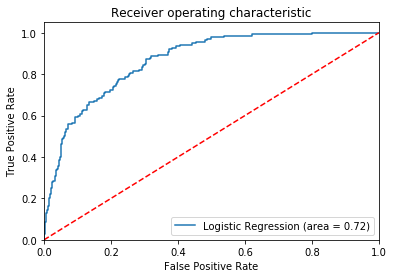

In [41]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Random forest classification

#### Hyperparameters Tuning Random forest model

In [53]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [54]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [55]:
rf = RandomForestClassifier(random_state = 42)

In [ ]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.3min


In [ ]:
rf_random.best_params_

In [53]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [1, 2, 3, 4],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [300,400,500]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [54]:
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  6.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [55]:
from sklearn.metrics import roc_auc_score
rf_grid_predictions = grid_search.predict(X_test)
# Probabilities for each class
rf_grid_search_probs = grid_search.predict_proba(X_test)[:, 1]
roc_value = roc_auc_score(y_test, rf_grid_search_probs)
roc_value_rf = roc_value
print(roc_value)

0.5412437386635276


[[   0  498]
 [   0 1003]]


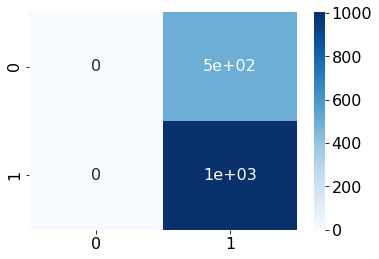

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion_matrix_rfc = confusion_matrix(y_test, rf_grid_predictions)
sns.heatmap(confusion_matrix_rfc, annot=True,cmap='Blues')
print(confusion_matrix_rfc)

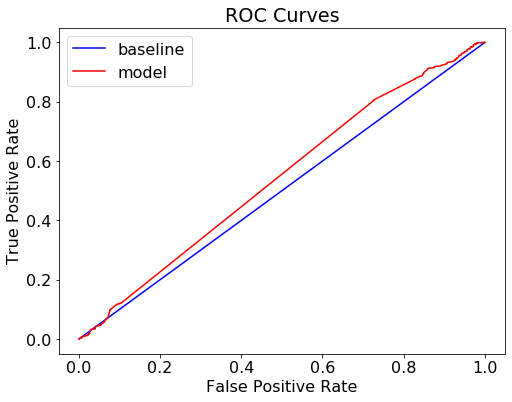

In [57]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve 
import matplotlib.pyplot as plt
# Calculate false positive rates and true positive rates
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, rf_grid_search_probs)

b = plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
    
# Plot both curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend();
plt.xlabel('False Positive Rate'); 
plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
plt.show();

In [58]:
print(classification_report(y_test,rf_grid_predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       498
           1       0.67      1.00      0.80      1003

    accuracy                           0.67      1501
   macro avg       0.33      0.50      0.40      1501
weighted avg       0.45      0.67      0.54      1501



C:\Users\Dumbo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### SVM Classifier

In [42]:
from sklearn.svm import SVC
svm_clf = SVC(gamma = "auto", probability=True)
svm_clf.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [43]:
y_svm_predict = svm_clf.predict(X_test)
y_svm_prob = svm_clf.predict_proba(X_test)[:,1]

[[1148  213]
 [  54   86]]


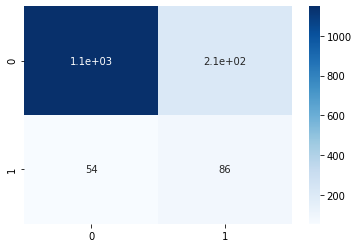

In [44]:
from sklearn.metrics import confusion_matrix
confusion_matrix_svm = confusion_matrix(y_test, y_svm_predict)
sns.heatmap(confusion_matrix_svm, annot=True,cmap='Blues')
print(confusion_matrix_svm)

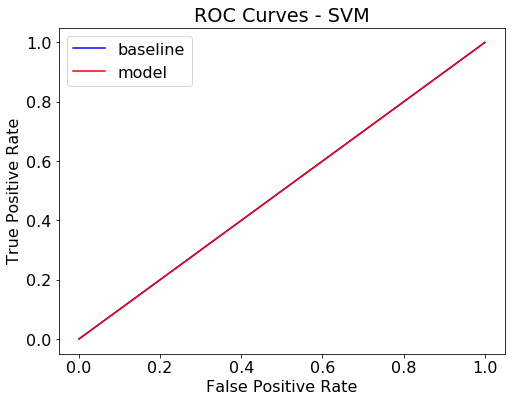

In [45]:
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, y_svm_prob)

a = plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
    
# Plot both curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend();
plt.xlabel('False Positive Rate'); 
plt.ylabel('True Positive Rate'); plt.title('ROC Curves - SVM');
plt.show();

In [46]:
param_grid_svm = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
#grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
grid_search_svm = GridSearchCV(estimator = svm_clf,param_grid = param_grid_svm, cv = 5, n_jobs = -1, verbose = 2)

In [47]:
grid_search_svm.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 20.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [48]:
y_svm_predict_gridsearch = grid_search_svm.predict(X_test)
y_svm_prob_gridsearch = grid_search_svm.predict_proba(X_test)[:,1]
roc_value = roc_auc_score(y_test, y_svm_prob_gridsearch)
roc_value_svm = roc_value
print(roc_value)

0.866999055316469


[[1360    1]
 [ 135    5]]


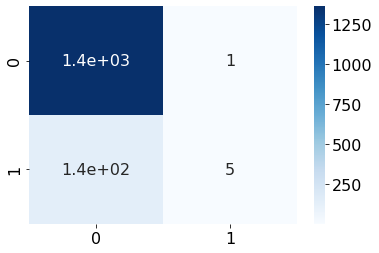

In [49]:
from sklearn.metrics import confusion_matrix
confusion_matrix_svm = confusion_matrix(y_test, y_svm_predict_gridsearch)
plot_svm = sns.heatmap(confusion_matrix_svm, annot=True,cmap='Blues')
print(confusion_matrix_svm)

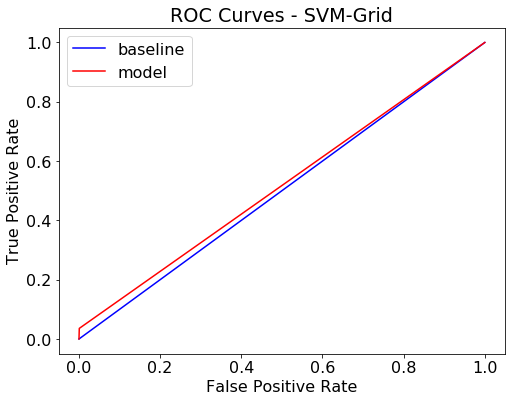

In [50]:
# Calculate false positive rates and true positive rates
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, y_svm_predict_gridsearch)

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
    
# Plot both curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend();
plt.xlabel('False Positive Rate'); 
plt.ylabel('True Positive Rate'); plt.title('ROC Curves - SVM-Grid');
plt.show();

In [52]:
print(classification_report(y_test,y_svm_predict_gridsearch))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1361
           1       0.83      0.04      0.07       140

    accuracy                           0.91      1501
   macro avg       0.87      0.52      0.51      1501
weighted avg       0.90      0.91      0.87      1501



In [68]:
print("The model accuracy for logistic regressio:",accuracy_log_reg,"\n The model accuracy for random forest",roc_value_rf,"\n The model accuracy for SVM ",roc_value_svm)

NameError: name 'roc_value_rf' is not defined

In [71]:
print("Classification report for SVM:\n",classification_report(y_test,y_svm_predict_gridsearch),"\nClassification report for random forest\n",classification_report(y_test,rf_grid_predictions),"\nClassification report for Logistic regression\n",classification_report(y_test, y_pred))

Classification report for SVM:
               precision    recall  f1-score   support

           0       0.71      0.42      0.52       498
           1       0.76      0.92      0.83      1003

    accuracy                           0.75      1501
   macro avg       0.73      0.67      0.68      1501
weighted avg       0.74      0.75      0.73      1501
 
Classification report for random forest
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       498
           1       0.67      1.00      0.80      1003

    accuracy                           0.67      1501
   macro avg       0.33      0.50      0.40      1501
weighted avg       0.45      0.67      0.54      1501
 
Classification report for Logistic regression
               precision    recall  f1-score   support

           0       0.77      0.30      0.44       498
           1       0.73      0.96      0.83      1003

    accuracy                           0.74      1501
   mac

C:\Users\Dumbo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("On comparing the three models, Logistic regression has given higher accuracy with better recall. Hence logistic regression is the best model among the three")